In [ ]:
 # Clone the repo.
!git clone https://github.com/mcogoni/APET.git

# Change the working directory to the repo root.
%cd APET

# Add the repo root to the Python path.
import sys, os
sys.path.append(os.getcwd())

# Install suntime for astro info
!pip3 install suntime

In [12]:
%pylab inline

from spot_processing import Station
from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time
from coords_utils import *
from wspr_utils import *
from suntime import Sun, SunTimeException

# Ionosonde data (Roma)
# http://ionos.ingv.it/Roma/hourly_data/

################################################
# IMPORTANT IN ORDER TO HAVE MEANINGFUL RESULTS!
rx_offset = 3   # rx sensitivity difference (db) 
                # between two receivers (should
                # be done by connecting both rx
                # to the same antenna)
###############################################

band = 20 # 20 meters band or whatever
spot_number = 5000 # how many spots to download matching the following callsign criteria
reporter_list =  ["IS0KYB", "IS0KYB1"] # The first is the reference antenna (omnidirectional if possible: small magnetic loop or vertical dipole)
reporter_loc = "JM49jn" # Locator of RX antennas

rep_lat, rep_lon = loc2coords(reporter_loc) # get QTH coords

sun = Sun(rep_lat, rep_lon) # create the Sun object to gather astro data

# Get today's sunrise and sunset in UTC
today_sr = sun.get_sunrise_time()
today_ss = sun.get_sunset_time()
print ("*"*50)
print ("Today Sunrise: %s" % today_sr)
print ("Today Sunset: %s" % today_ss)
print ("*"*50)

timestamp_start = get_unixtime("2019-04-10 15:40") # Filter spots earlier than this (UTC!)
timestamp_stop = get_unixtime("2019-04-10 21:25") # Filter any spot later than this

use_symmetry = False # use this flag to enrich data from one angle also for angle+180 STILL BUGGY DO NOT USE! Leave it to False 

antenna_rotation_time = get_unixtime("2019-04-10 15:40") # ignore this, experimental feature
angle_offset = -90.

# download and parse data from WSPR db
contents = []
for reporter in reporter_list:
    tmp = download_wspr_data(band, spot_number, reporter)
    contents.append(tmp)
reporter_loc_dict, d_dict= extract_wspr_data(contents, timestamp_start, timestamp_stop)
dist_dict, coord_dict, callsign_dict = extract_info(d_dict)

Populating the interactive namespace from numpy and matplotlib
**************************************************
Today Sunrise: 2019-04-11 04:55:00+00:00
Today Sunset: 2019-04-11 17:58:00+00:00
**************************************************


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'sin', 'degrees', 'radians', 'sqrt', 'pi', 'cos']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# get the most spotted stations and their occurrences

callsign_sorted_byspots = most_spotted(callsign_dict)
data_bycallsign_dict = data_by_callsign(callsign_sorted_byspots, d_dict)

In [3]:
# create a dictionary of sorted SNR timeseries with [call] and [reporter] as keys

snr_dict = get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, topn=-1, plot_flag=False)

In [4]:
# compute the common parts (wrt reporters) of timeseries (return timestamps for both reporters)

common_ts_bycall = data_by_callsign_common(data_bycallsign_dict, reporter_list)

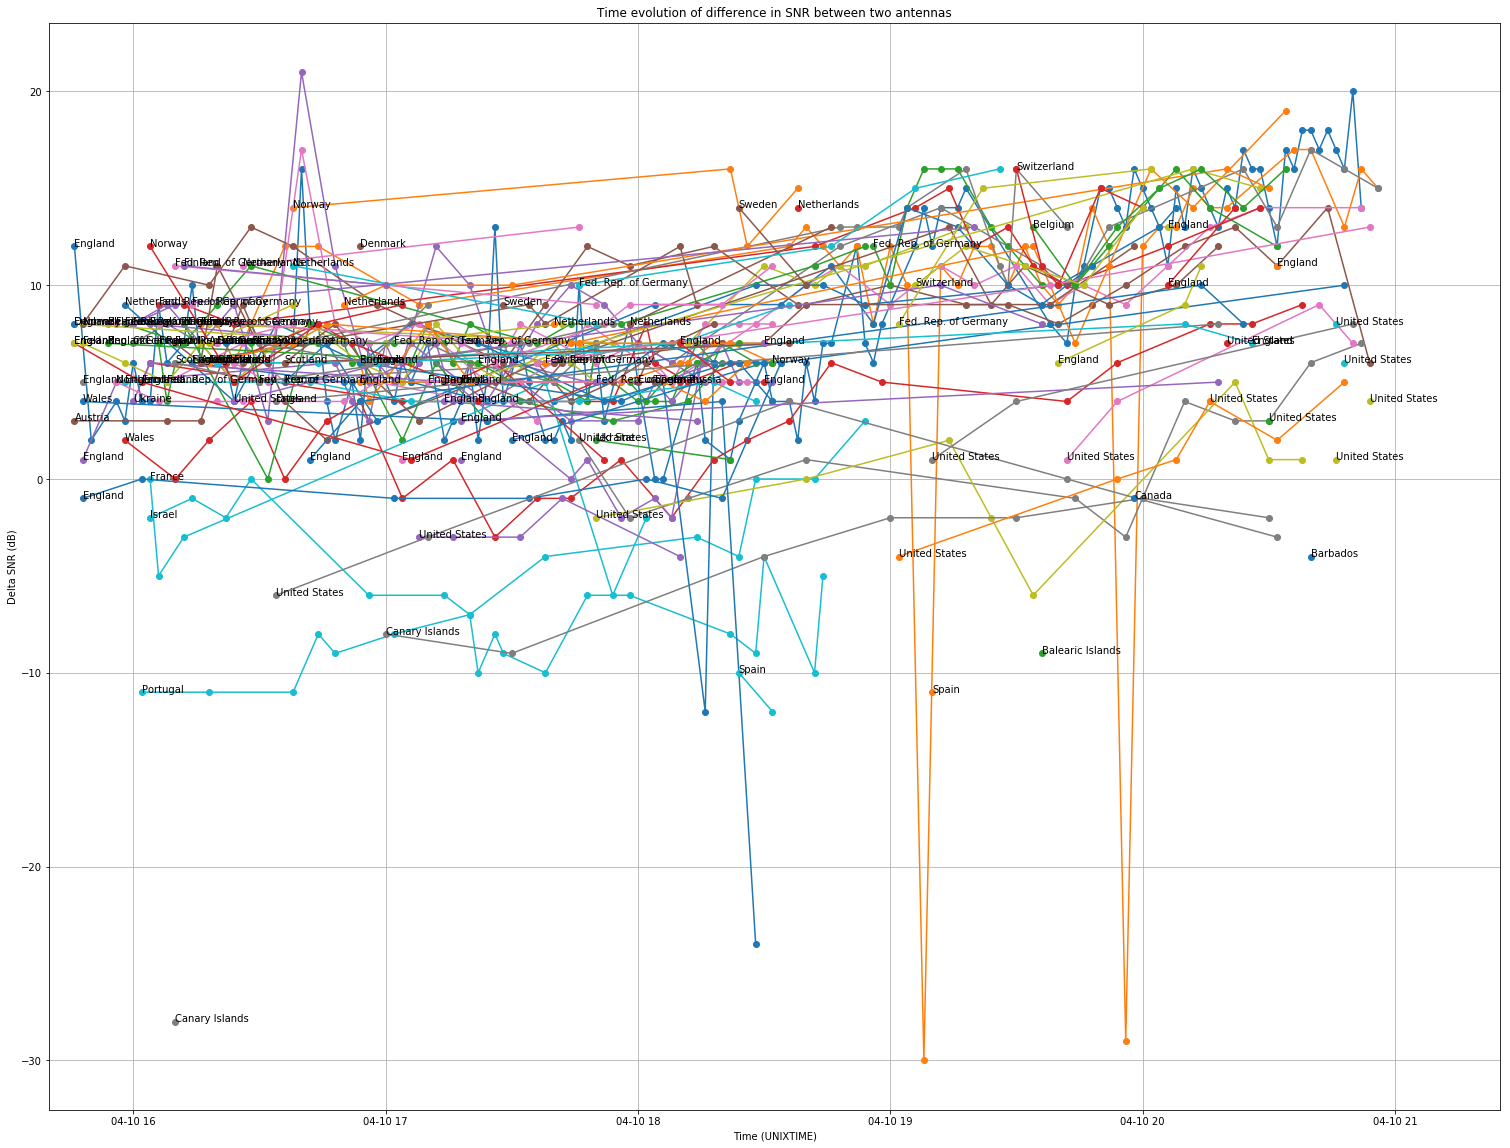

In [5]:
# create a dictionary of sorted DELTA SNR timeseries with [call] as key

deltasnr_dict = get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=True, country=True)

(-10, 370)

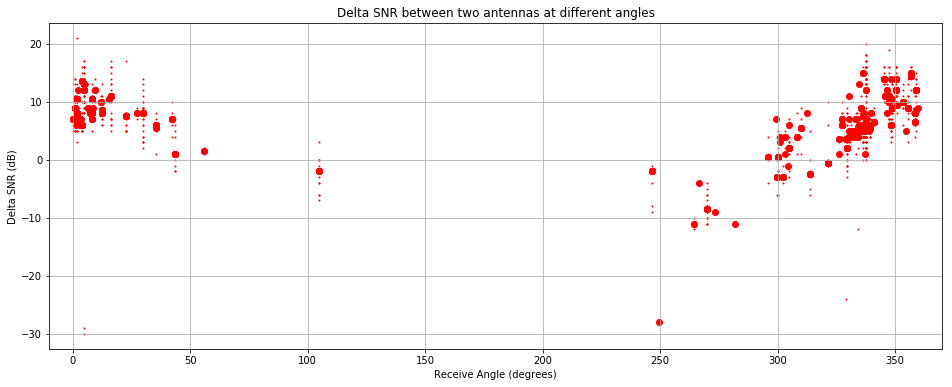

In [6]:
# Scatter plot of the difference in dB between the two antennas

plt.figure(figsize=(16,6))
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] for el in deltasnr_list[0] if el >= antenna_rotation_time]
    az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset) for el in deltasnr_list[0] if el < antenna_rotation_time]
    deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
    deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]
    
    plt.scatter(az_list1, deltasnr_list1, s=1, c="r")
    plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], c="r") #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
    plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
    plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
plt.grid()
plt.title("Delta SNR between two antennas at different angles")
plt.xlabel("Receive Angle (degrees)")
plt.ylabel("Delta SNR (dB)")
plt.xlim(-10,370)

/usr/lib/python3/dist-packages/matplotlib/projections/polar.py:162: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)


Text(0.5, 1.05, 'Polar Plot of the Delta SNR in dB')

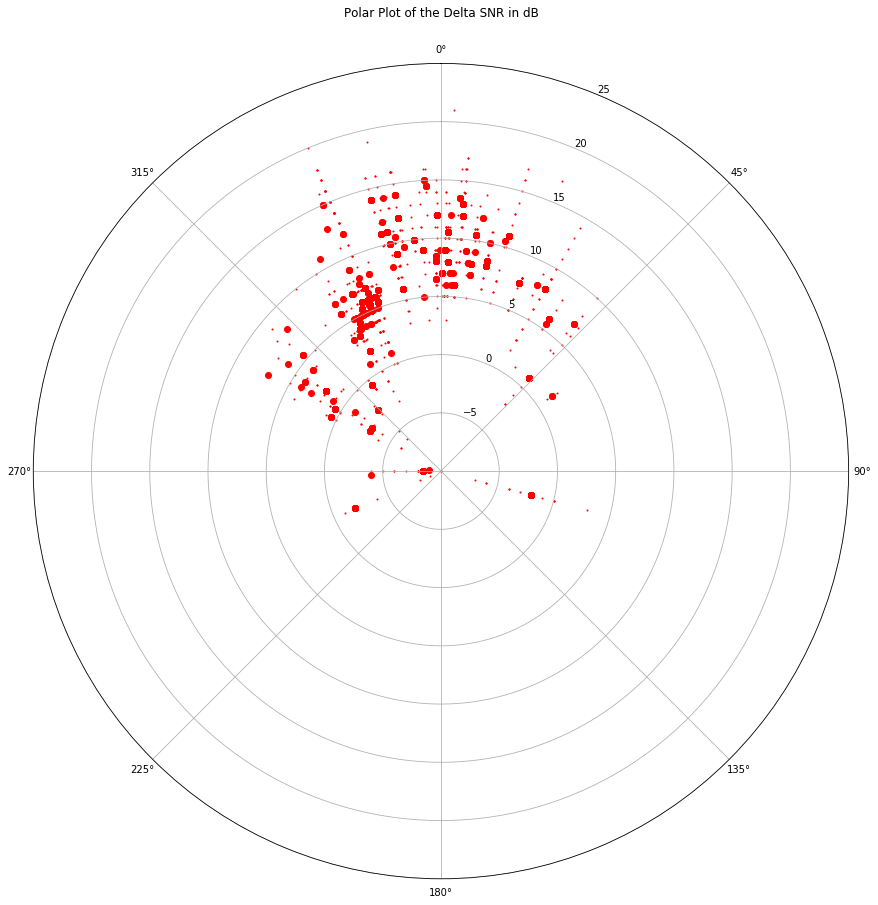

In [7]:
# Polar scatter plot of the difference in dB between the two antennas

az_complete_list = []
deltasnr_complete_list = []

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    
    az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi for el in deltasnr_list[0] if el >= antenna_rotation_time]
    az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset)/360.*2*pi for el in deltasnr_list[0] if el < antenna_rotation_time]
    deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
    deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]
    
    if len(az_list1):
        for az, deltasnr in zip(az_list1, deltasnr_list1):
            az_complete_list.append(az)
            deltasnr_complete_list.append(deltasnr)
    if len(az_list2):
        for az, deltasnr in zip(az_list2, deltasnr_list2):
            az_complete_list.append(az)
            deltasnr_complete_list.append(deltasnr)
    
    plt.scatter(az_list1, deltasnr_list1, s=1, c="r")
    plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], c="r") #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
    plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
    plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,25)
plt.title("Polar Plot of the Delta SNR in dB")
#az_complete_list = [a for a in el for el in az_complete_list]
#deltasnr_complete_list = [a for a in el for el in deltasnr_complete_list]

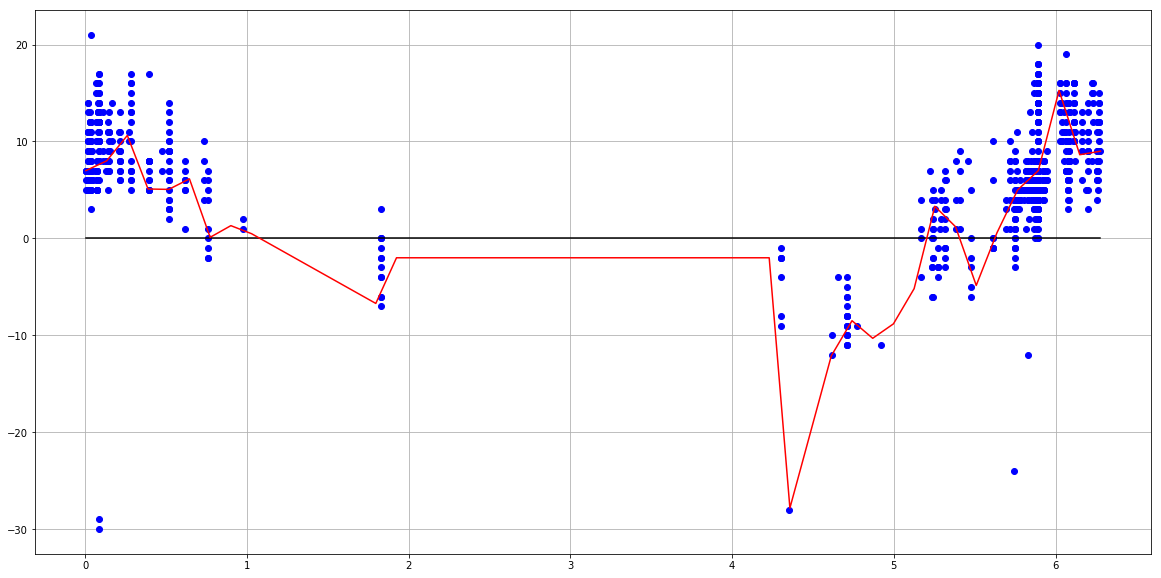

In [8]:
# Here we convert degrees to radians and perform a rough 1D interpolation 

az_rad_list = []
for i,v in enumerate(az_complete_list):
    az_rad_list.append( v + 0.0001*(2*rand()-1.) )
    if use_symmetry:
        az_rad_list.append((v+pi) %(2*pi))
        deltasnr_complete_list.append(deltasnr_complete_list[i])
    
angles, gains = zip(*sorted(zip(az_rad_list, deltasnr_complete_list)))

x = np.array(angles)
y = np.array(gains)

x0 = np.linspace(np.min(x),np.max(x))
y0 = np.zeros(x0.shape)

f = interpolate.interp1d(x, y, kind="linear")
figure(figsize=(20,10))
plot(x, y, 'bo', label = 'Original')
plot(x0, y0, 'k', label = 'Zero')
plot(x0, f(x0), 'r', label = 'Interpolated')
grid()
#xlim(0,6.28)
#ylim(-30,30)

(-10, 30)

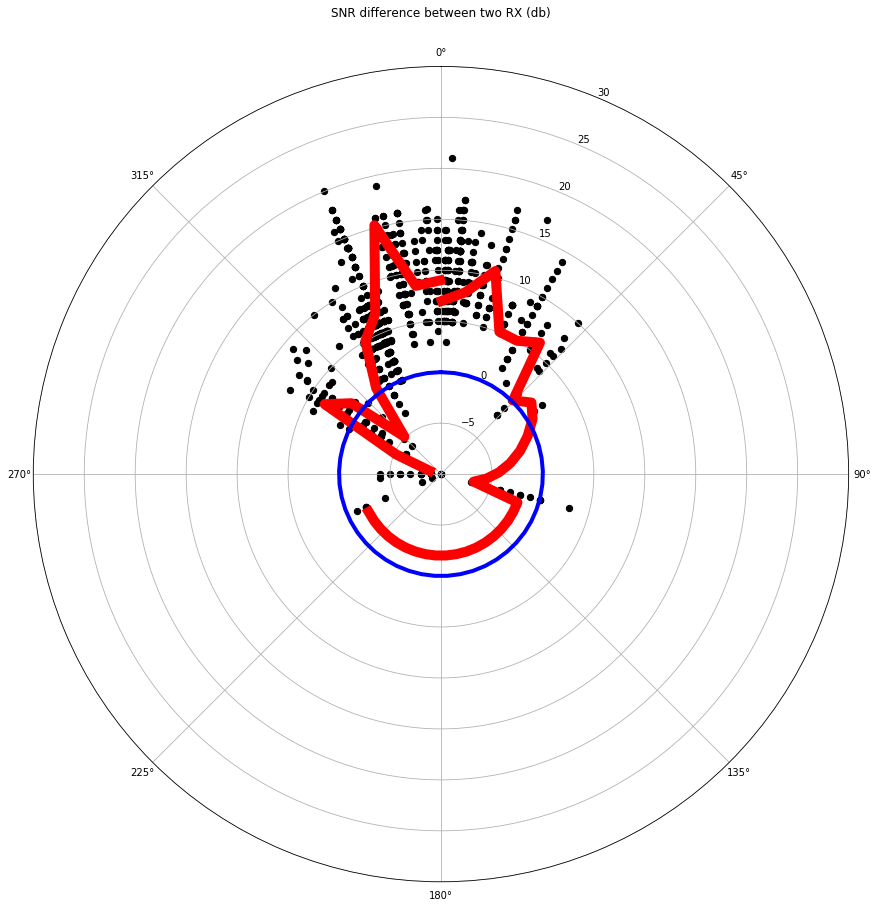

In [9]:
# Now let's finally plot the polar graph with the real SNR deltas and their interpolation
# Moreover, we plot the angular distance distribution of the spots

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
c = ax.plot(x0, f(x0), c='r', linewidth=10)
c0 = ax.plot(x0, y0, c='b', linewidth=4)
c2 = ax.scatter(x, y, c='k', s=40)

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,30)

#fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(111, projection='polar')
#ax.set_title("Distance distribution of the received stations (km)", va='bottom')


#c2 = ax.scatter(x, dist_list, c='k', s=80)

#ax.set_theta_zero_location('N', offset=0)
#ax.set_theta_direction(-1)
